In [1]:
# Scientific libraries
import numpy as np
import scipy.stats as stats
import scipy.special as sf
import scipy.integrate as integrate
import scipy.interpolate as interpolate

# import Pandas

import pandas as pd

#astro
from astropy.cosmology import WMAP9 as cosmo
import astropy.io.fits as fits
import astropy.units as u
import astropy.constants as const

# Graphic libraries

%matplotlib notebook
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(context='notebook', fscale=1)
import seaborn as sns

#optional 3ML imports

from threeML import *
#from astromodels.xspec.xspec_settings import *
#from astromodels.xspec.factory import *

#useful libraries

from glob import glob
import copy
import collections
#import warnings
#warnings.simplefilter('ignore')
from threeML.utils.interval import IntervalSet

Configuration read from /Users/jburgess/.threeML/threeML_config.yml


In [2]:
f = fits.open('spi_oper.fits.gz')

In [3]:
f.info()

Filename: spi_oper.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      20   ()      
  1  SPI.-OSGL-ALL    1 BinTableHDU     91   2022045R x 6C   [1I, 1B, 1I, 4I, 1E, 1D]   
  2  SPI.-OPSD-ALL    1 BinTableHDU    107   475335R x 13C   [1I, 1B, 1I, 1B, 1I, 4I, 1B, 1B, 1B, 1E, 1E, 1B, 1D]   
  3  SPI.-OCRV-ALL    1 BinTableHDU    171   834R x 35C   [1I, 1B, 1I, 1B, 1I, 1I, 79I, 4I, 1B, 1B, 1B, 1E, 1B, 1B, 1B, 1B, 1B, 1I, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1B, 1B, 1B, 1E, 1E, 1E, 1B, 1D]   
  4  SPI.-OME2-ALL    1 BinTableHDU     95   298783R x 8C   [1I, 2B, 2I, 2B, 4I, 1B, 2E, 1D]   
  5  SPI.-OME3-ALL    1 BinTableHDU     95   56421R x 8C   [1I, 3B, 3I, 3B, 4I, 1B, 3E, 1D]   
  6  SPI.-OME4-ALL    1 BinTableHDU     95   9782R x 8C   [1I, 4B, 4I, 4B, 4I, 1B, 4E, 1D]   
  7  SPI.-OME5-ALL    1 BinTableHDU     95   1570R x 8C   [1I, 5B, 5I, 5B, 4I, 1B, 5E, 1D]   
  8  SPI.-OMEH-ALL    1 BinTableHDU     97   274R x 9C   [1I, 1B, 31B, 3

In [6]:
f['SPI.-OSGL-ALL'].data['TIME_TAG']

array([   1,   48,   74, ..., 1142, 1166, 1199], dtype=uint16)

In [7]:
f['SPI.-OSGL-ALL'].data['ENERGY']

array([320.42343 , 105.56023 , 171.2136  , ...,  65.336174,  65.0411  ,
       430.70444 ], dtype=float32)

In [33]:
import re

def _parse_interval(time_interval):
    # The following regular expression matches any two numbers, positive or negative,
     # like "-10 --5","-10 - -5", "-10-5", "5-10" and so on

    tokens = re.match('(\-?\+?[0-9]+\.?[0-9]*)\s*-\s*(\-?\+?[0-9]+\.?[0-9]*)', time_interval).groups()

    return map(float, tokens)

class SPIData(object):
    
    def __init__(self, data_file, orbital_file):
        
        self._data_file = data_file
        
        
        self._n_detectors = 19
        
        extensions = ['SPI.-OSGL-ALL','SPI.-OPSD-ALL'] 
        data_types = ['single','pulse_shape']
        
        self._data_types = collections.OrderedDict()
        
        for ext, dtype in zip(extensions,data_types):
            
            
            tmp = collections.OrderedDict()
            energy, arrival_time = self._extract_event_type(ext)
            
            tmp['arrival_time'] = arrival_time
            tmp['energy'] = energy 
            
            
            self._data_types[dtype] = tmp 
            
            
            
            
    @property
    def data_types(self):
        
        return self._data_types
            
        
            
    def _extract_event_type(self, extension):
        
        with fits.open(self._data_file) as f:
            
            arrival_time = f[extension].data['TIME_TAG']
            energy = f[extension].data['ENERGY']
            detector_number = f[extension].data['DETE']
            
            
        # now sepearate events into detectors
        
        energies_per_detector = []
        arrival_times_per_detector = []
        
        for det in range(self._n_detectors):
            
            det_selection = detector_number == det
            ene = energy[det_selection]
            at = arrival_time[det_selection]
            
            energies_per_detector.append(ene)
            
            arrival_times_per_detector.append(at)
            
        
        return np.array(energies_per_detector), np.array(arrival_times_per_detector)
        
    
    def _calculate_exposure(self, *time_selections):
        
        return 1.
    
    
    def to_observation(self, *time_selections):
        
        selections = [_parse_interval(x) for x in time_selections]
        
        # first 
        new_data = collections.OrderedDict()
        
        for key, value in self._data_types:
            
            # first we create the logical array for the time
            
            new_energies = []
            
            # loop through all detectors
            for i, arr_time in enumerate(value['arrival_times']):

                cond = np.ones(len(arr_time))

                for selection in selections:

                    new_condition = (arr_time >= selection[0]) & (arr_time <= selection[1])

                    cond = np.logical_and(cond, new_condition)

                selected_energies = value['energy'][i][cond]
                
                new_energies.append(selected_energies)
                
            new_data[key] = np.array(new_energies)
            
        exposure = self._calculate_exposure(*time_selections)
        
        return SPIObservation(new_data, exposure=exposure)
            
            
        
                
            
            
            
            
            
            
            
            
            
            
            
            
            
            
        
        
        
        

# increase later
_known_data_types = ['single','pulse_shape','multiple']        
_single_event_data_types = ['single','pulse_shape']


def _single_energy_filter(energies):
    
    idx = (energies <= 100.) & (3000. <= energies)
    
    return energies[idx]

def _pulse_shape_energy_filter(energies):
    
    idx = (energies > 100.) & (3000. < energies)
    
    return energies[idx]
    

class SPIObservation(class):
    
    def __init__(observation_dict, exposure):
        
        
        self._exposure = exposure
        
        self._process_observation(observation_dict)
 
    
    def _process_observation(self, observation_dict):
        
        
        # here is where we want to sum single and PSD data
        # etc
        
        self._observation_dict = observation_dict
        self._event_type = collections.OrderedDict()
        
        # sum single observations but account for 
        # the strange shit in the different types
        
        
        
        
        
        for k,v in self._observation_dict.items():
            
            new_events = []
            
            # now we filter the energies
            if k in _single_event_data_types:
                if k == 'single':
                    
                    new_events.extend( _single_energy_filter(v))
                    
                elif k == 'pulse_shape':
                    
                    new_events.extend( _pulse_shape_energy_filter(v))
                else:
                    
                    raise RuntimeError('this is a bug')
                    
                    
                
        self._event_type['all_single'] = np.array(new_events)
        
        
    @property
    def expousre(self):
        
        return self._exposure
    
    @property
    def all_single_events(self):
        
        return self._event_type['single']
            
            
        
        
        
        
        
        
        
        
        
        
            
        
        
    
        
        
        

IndentationError: expected an indented block (<ipython-input-33-1e29a311c08a>, line 86)

In [17]:
spi = SPIData('spi_oper.fits.gz',None)

In [31]:
spi.data_types['pulse_shape']['arrival_time']

array([array([1036, 1165,  109, ...,  194,  273,  976], dtype=uint16),
       array([], dtype=uint16), array([], dtype=uint16),
       array([ 97, 563,  37, ..., 876, 576, 848], dtype=uint16),
       array([ 165,  455,  331, ...,  794, 1219,  938], dtype=uint16),
       array([], dtype=uint16),
       array([ 364, 1057,  745, ...,  419,  667,   44], dtype=uint16),
       array([212, 415, 269, ..., 877,  13, 139], dtype=uint16),
       array([631,   6, 538, ...,  61, 200, 908], dtype=uint16),
       array([ 60, 608, 646, ..., 874,  73, 378], dtype=uint16),
       array([ 454,  597,  722, ..., 1146,  886,  990], dtype=uint16),
       array([1145,  939,   53, ...,  383,  479,  585], dtype=uint16),
       array([  46,   57,   68, ...,  269,  486, 1070], dtype=uint16),
       array([ 167,  991,   65, ...,  350,  201, 1027], dtype=uint16),
       array([ 340,  600,  739, ..., 1054,  419, 1160], dtype=uint16),
       array([ 32, 616, 117, ..., 963, 977, 996], dtype=uint16),
       array([ 487

# fig, ax = plt.subplots()


ax.hist(spi.data_types['pulse_shape']['energy'][0],bins=100)

ax.hist(spi.data_types['single']['energy'][0],bins=100,alpha=.4)


ax.set_yscale('log')

<IPython.core.display.Javascript object>


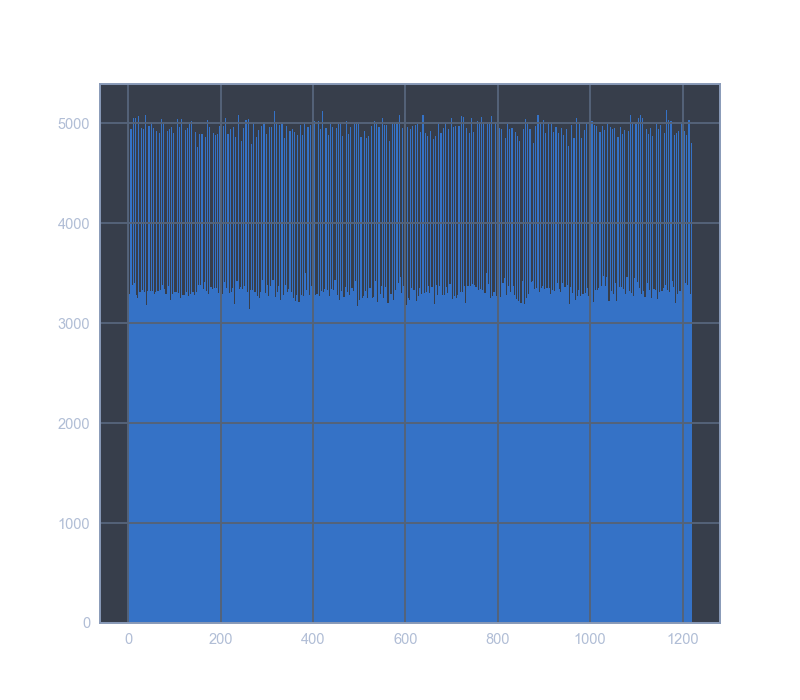

In [14]:
fig, ax = plt.subplots()


ax.hist(spi.arrival_time,bins=500);

<IPython.core.display.Javascript object>


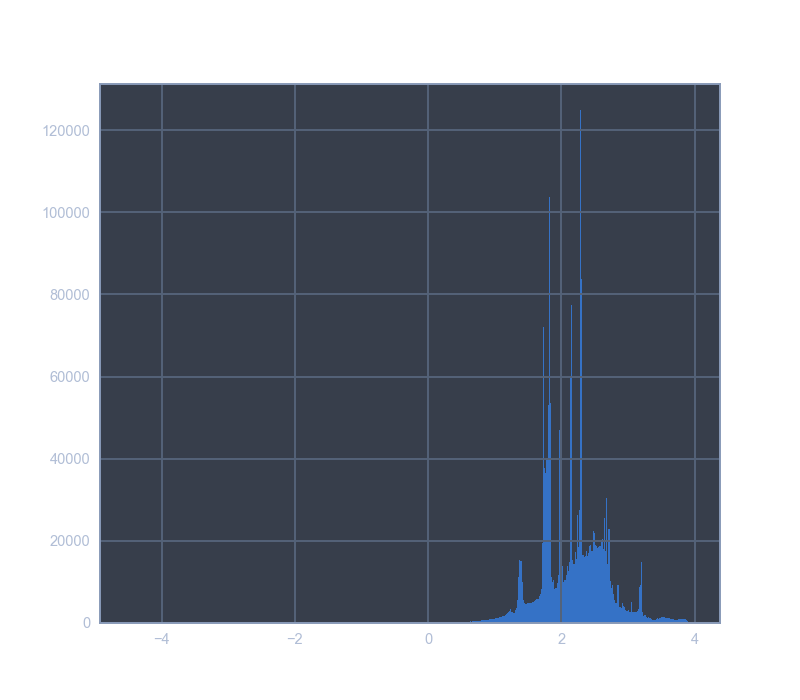

In [6]:
fig, ax = plt.subplots()


ax.hist(np.log10(spi.energy[spi.energy>0.]),bins=500);

In [8]:
spi.detector_number.max()

18

In [10]:
19*5

95

In [2]:
f = fits.open('convsky_model_SPI_GRB110903A.fits')

In [3]:
f.info()

Filename: convsky_model_SPI_GRB110903A.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   ()      
  1  GROUPING      1 BinTableHDU     29   1R x 6C   [8A, 32A, 1J, 1J, 256A, 3A]   
  2  SPI.-BMOD-DSP    1 BinTableHDU     82   19R x 2C   [16E, 16E]   


In [4]:
ext = f['SPI.-BMOD-DSP']

In [5]:
ext.data['COUNTS'].shape

(19, 16)

In [7]:
eb = fits.open('energy_boundaries.fits.gz')

In [8]:
def polar2cart(ra,dec):
    
    x = np.cos(np.deg2rad(ra)) * np.cos(np.deg2rad(dec))
    y = np.sin(np.deg2rad(ra)) * np.cos(np.deg2rad(dec))
    z = np.sin(np.deg2rad(dec))
    
    return np.array([x,y,z])



def cart2polar(vector):

    r=np.sqrt((np.array(vector)**2).sum())
    
    ra = np.arctan2(vector[1],vector[0])
    
    dec = np.arcsin(vector[2]/r)
    
    return np.rad2deg(ra), np.rad2deg(dec)
    
    
def construct_scy(scx_ra, scx_dec, scz_ra, scz_dec):
    
    x = polar2cart(scx_ra, scx_dec)
    z = polar2cart(scz_ra, scz_dec)
    
    return cart2polar(np.cross(x,-z))

In [7]:
construct_scy(206.3257, 50.62978, 142.1352  , -19.65908)

(65.30684615326929, 32.531710057415495)

In [9]:
emin = eb['SPI.-EBDS-SET'].data['E_MIN']
emax = eb['SPI.-EBDS-SET'].data['E_MAX']


ebounds = np.append(emin,emax[-1])

In [10]:
from pyspi.spi_frame import SPIFrame


WARNING FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [21]:
spi_frame = SPIFrame(0.*u.deg,0.*u.deg,
                     scx_ra=206.32522477,
                     scx_dec=50.62928435,
                     scy_ra=65.30684615326929,
                     scy_dec= 32.531710057415495,
                     scz_ra= 142.1352,
                     scz_dec=-19.65908)

In [22]:
from astropy.coordinates import SkyCoord

source = SkyCoord(ra=197.075, dec=58.98,unit='deg',frame='icrs')

In [25]:
source.transform_to(spi_frame).spherical

<SphericalRepresentation (lon, lat, distance) in (deg, deg, )
    (9.87233837, -0.54641702, 1.)>

In [24]:
source.spherical

<SphericalRepresentation (lon, lat, distance) in (deg, deg, )
    (197.075, 58.98, 1.)>

In [14]:
from pyspi import SPIResponse

In [15]:
spi = SPIResponse()

In [16]:
spi.get_xy_pos(np.deg2rad(-0.54641702),np.deg2rad(9.87232987))

(66.74376185743458, 46.811702455437455)

In [26]:
spi.get_xy_pos(np.deg2rad(360-0.54641702),np.deg2rad(9.87233837)
                                    )

(66.7437788566615, 46.81170229331473)

In [18]:
spi._get_irf_weights(66.773967,45.601441)

(array([0.09008749, 0.30847151, 0.13594551, 0.46549549]),
 array([66, 67, 66, 67]),
 array([45, 45, 46, 46]))

In [26]:
spi._irf_ymin

-0.4145156973486533

In [27]:
bea = spi.get_binned_effective_area(np.deg2rad(360-0.54641702),np.deg2rad(9.87233837), ebounds)


WARNING IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


WARNING IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


WARNING IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.



<IPython.core.display.Javascript object>


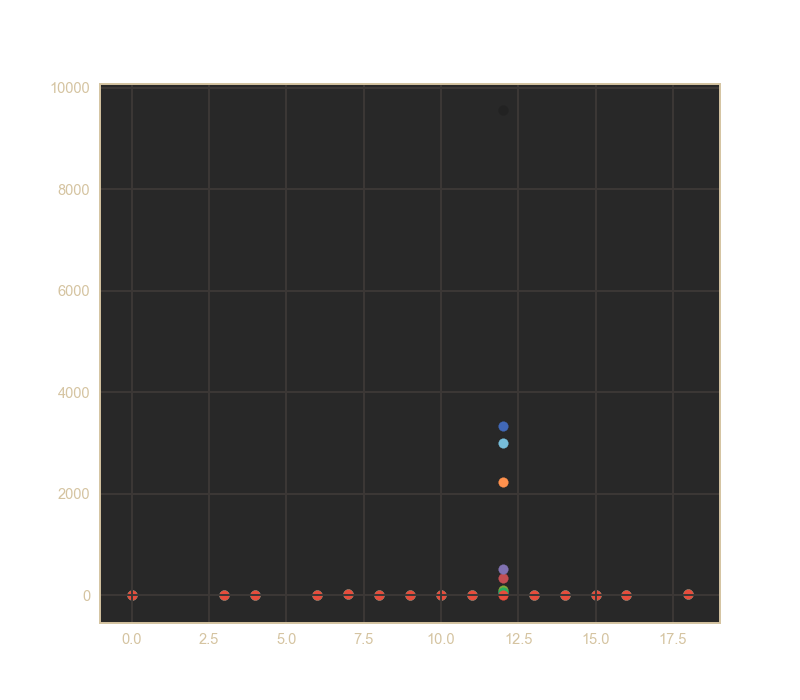


WARNING RuntimeWarning: invalid value encountered in divide


WARNING RuntimeWarning: invalid value encountered in divide


WARNING RuntimeWarning: invalid value encountered in divide


WARNING RuntimeWarning: invalid value encountered in divide


WARNING RuntimeWarning: invalid value encountered in divide


WARNING RuntimeWarning: invalid value encountered in divide


WARNING RuntimeWarning: invalid value encountered in divide


WARNING RuntimeWarning: invalid value encountered in divide


WARNING RuntimeWarning: invalid value encountered in divide


WARNING RuntimeWarning: invalid value encountered in divide



In [29]:
fig, ax = plt.subplots()
ch=1

width = 0.35
ind = np.arange(19)
for ch in range(10):
    ax.scatter(ind, bea[:19,ch]/ ext.data['COUNTS'][:,ch],label='me')
#ax.semilogy(ind, ext.data['COUNTS'][:,ch],'o',label='them',alpha=.7)

#ax.set_xticks(ind + width / 2)
#ax.set_xticklabels(range(19))


#ax.legend()

In [24]:
ext.data['COUNTS'][:,0].shape

(19,)

In [16]:
f = fits.open('sc_orbit_param.fits.gz')

In [17]:
f.info()

Filename: sc_orbit_param.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      20   ()      
  1  INTL-ORBI-SCP    1 BinTableHDU     90   417R x 16C   [4I, 1I, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   


In [21]:
f['INTL-ORBI-SCP'].data

FITS_rec([([     1,   2871,  48496,      0],   1085, 0.47288859, 1085.47288859, 165611.20748414, 70303.38081812, -19301.18658332, 148700.94447035, -0.2304204 , 0.38572736, 0.25988573, 206.15632629, 50.54383469, 142.12562561, -19.81947136, 122.24489369),
          ([     1,   2871,  48624,      0],   1085, 0.47291953, 1085.47291953, 165611.93170326, 70301.53725645, -19298.10070851, 148703.02313978, -0.23046976, 0.38574091, 0.25978134, 206.15632629, 50.54383469, 142.12562561, -19.81947136, 122.24489369),
          ([     1,   2871,  48752,      0],   1085, 0.47295048, 1085.47295048, 165612.65509322, 70299.69329993, -19295.01472529, 148705.10097408, -0.23051911, 0.38575446, 0.25967694, 206.15632629, 50.54383469, 142.12562561, -19.81947136, 122.24489369),
          ([     1,   2871,  48880,      0],   1085, 0.47298142, 1085.47298142, 165613.37765403, 70297.84894856, -19291.92863365, 148707.17797328, -0.23056846, 0.385768  , 0.25957255, 206.15632629, 50.54383469, 142.12562561, -19.81947136,